# Kaggle Readability prize playground

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pandas.io.json import json_normalize

import os

In [2]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [3]:
train_set = '../datasets/commonlitreadabilityprize/train.csv'
test_set = '../datasets/commonlitreadabilityprize/test.csv'
submit_sample = '../datasets/commonlitreadabilityprize/sample_submission.csv'

In [4]:
df = pd.read_csv(train_set)
df.columns

Index(['id', 'url_legal', 'license', 'excerpt', 'target', 'standard_error'], dtype='object')

## Columns
* id - unique ID for excerpt
* url_legal - URL of source - this is blank in the test set.
* license - license of source material - this is blank in the test set.
* excerpt - text to predict reading ease of
* target - reading ease
* standard_error - measure of spread of scores among multiple raters for each excerpt. Not included for test data.

In [5]:
df.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [6]:
len(df)

2834

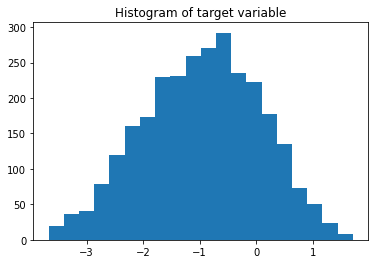

count    2834.000000
mean       -0.959319
std         1.033579
min        -3.676268
25%        -1.690320
50%        -0.912190
75%        -0.202540
max         1.711390
Name: target, dtype: float64


In [7]:
plt.hist(df.target, bins = 20)
plt.title("Histogram of target variable")
plt.show()
print(df.target.describe())

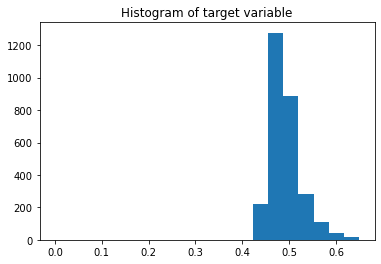

count    2834.000000
mean        0.491435
std         0.034818
min         0.000000
25%         0.468543
50%         0.484721
75%         0.506268
max         0.649671
Name: standard_error, dtype: float64


In [8]:
plt.hist(df.standard_error, bins = 20)
plt.title("Histogram of target variable")
plt.show()
print(df.standard_error.describe())

## Cleaning
* Hay algunos NaN pero en columnas irrelevantes.
* Ojo, hay rates 0.0 en una fila: por eso la distorsión en el min del std_err

In [9]:
df[df['target'] == 0.0]

,id,url_legal,license,excerpt,target,standard_error
106,436ce79fe,NaN,NaN,"The sun was shining in a cloudless sky, and no...",0.0,0.0


In [10]:
df = df.drop([106])

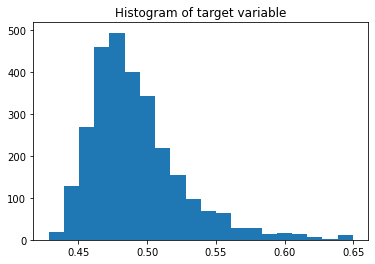

count    2833.000000
mean        0.491609
std         0.033577
min         0.428233
25%         0.468553
50%         0.484748
75%         0.506304
max         0.649671
Name: standard_error, dtype: float64


In [11]:
plt.hist(df.standard_error, bins = 20)
plt.title("Histogram of target variable")
plt.show()
print(df.standard_error.describe())

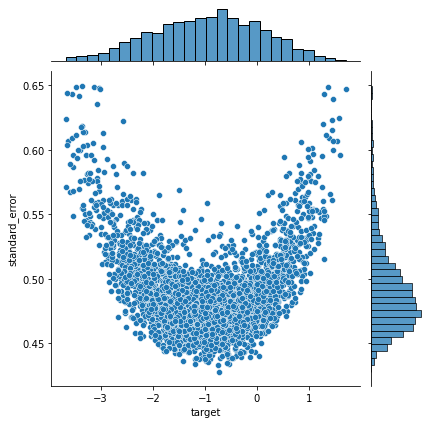

In [12]:
sns.jointplot(x='target', y='standard_error', data=df)

## De acuerdo
* Veamos los textos donde los raters estuvieron de acuerdo sobre su facilidad de lectura:
* Ordenado por mayor target (y observemos el standard error).


## Los mejores textos:

In [13]:
mejores = df[['id','excerpt', 'target', 'standard_error']].sort_values('target', ascending = False)[:20]

In [14]:
mejores.head()

,id,excerpt,target,standard_error
2829,25ca8f498,When you think of dinosaurs and where they liv...,1.711390,0.646900
981,849971671,"For her last birthday, Sisanda had a special t...",1.597870,0.596349
808,8f35441e3,"Every day, Emeka's father took him to school i...",1.583847,0.624776
1014,7a1d484be,More people came to the bus stop just before 9...,1.541672,0.606997
1066,016913371,Grandma's garden was wonderful. It was full of...,1.467665,0.599600


## Los peores textos:

In [15]:
peores = df[['id','excerpt', 'target', 'standard_error']].sort_values('target', ascending = True)[:20]
peores.head()

,id,excerpt,target,standard_error
1705,4626100d8,"The commutator is peculiar, consisting of only...",-3.676268,0.623621
1128,493b80aa7,The Dunwich horror itself came between Lammas ...,-3.668360,0.571404
1754,fe44cbd14,"The iron cylinder weighs 23 kilogrammes; but, ...",-3.642892,0.644398
1752,284eaa5ad,As to surface-slope its measurement—from nearl...,-3.639936,0.603819
1720,9e9eacb49,"The tree is dioecious, bearing male catkins on...",-3.636834,0.606822


## Observaciones
* 1. 
* 2. 

### Feature Engineering: Generating some basic features

In [16]:
df['word_count'] = df['excerpt'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['excerpt'].apply(lambda x: len(str(x)))
df['avg_word_length'] = df['char_count'] / df['word_count']

df['unique_words_count'] = df['excerpt'].apply(lambda x: len(set( x.split(' ') )))
df['diversity'] = df['unique_words_count'] / df['word_count']

df.head()

,id,url_legal,license,excerpt,target,standard_error,word_count,char_count,avg_word_length,unique_words_count,diversity
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,179,992,5.541899,112,0.625698
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,169,937,5.544379,123,0.727811
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,166,908,5.469880,124,0.746988
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,164,909,5.542683,117,0.713415
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,147,723,4.918367,51,0.346939


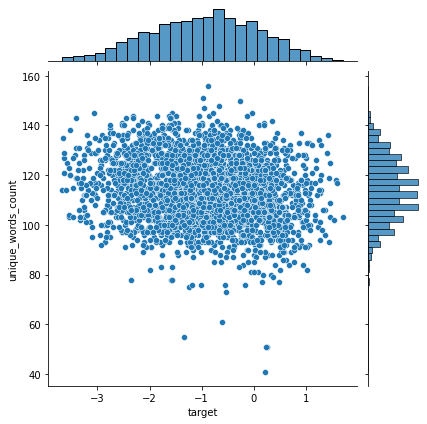

In [17]:
sns.jointplot(x='target', y='unique_words_count', data=df)